Transfer Learning, Image Search, and Segmentation
Agenda:

1. The "Engine" of Search: Strip a pre-trained ResNet to create a Feature Extractor.
2. Reverse Image Search: Build a system that takes a query image and finds the most similar images in a database using Cosine Similarity.
3. Semantic Segmentation: Implement the "Mask" data loading pipeline (handling the resizing trap) and build a simple UNet architecture.



In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Part 1: Building a Feature Extractor (Transfer Learning)
We want to use a pre-trained ResNet-18, but we don't care about the classification (Cat vs. Dog). We care about the vector right before the classification layer.

In [54]:
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

print("Original Last Layer:", model.fc)

model.fc = nn.Identity()
print("New Last Layer:", model.fc)

model = model.to(device)
model.eval()

dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy_input)
print("New Output Shape (Embedding):", output.shape)

Original Last Layer: Linear(in_features=512, out_features=1000, bias=True)
New Last Layer: Identity()
New Output Shape (Embedding): torch.Size([1, 512])


## Part 2: Reverse Image Search

In [55]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
subset_indices = list(range(100))
database_dataset = Subset(full_dataset, subset_indices)
dataloader = DataLoader(database_dataset, batch_size=20, shuffle=False)

def show_img(tensor_img):
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_normalize(tensor_img).permute(1, 2, 0).cpu().numpy()
    plt.imshow(np.clip(img, 0, 1))
    plt.axis('off')

In [ ]:
database_embeddings = []
database_images = []

print("Extracting features...")
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        embeddings = model(images)
        database_embeddings.append(embeddings.cpu().numpy())
        database_images.append(images.cpu())

database_embeddings = np.concatenate(database_embeddings)
database_images = torch.cat(database_images)

print(f"Database Shape: {database_embeddings.shape}")
print(f"Database Images Shape: {database_images.shape}")

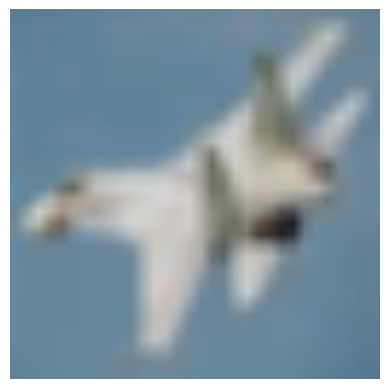

In [56]:
query_idx = 10
show_img(database_images[query_idx])

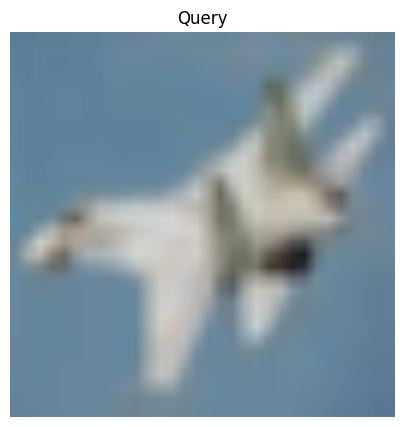

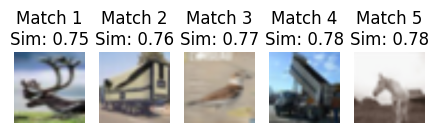

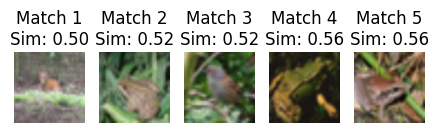

In [57]:
query_embedding = database_embeddings[query_idx].reshape(1, -1)

similarities = cosine_similarity(query_embedding, database_embeddings)
sorted_similarity = similarities.argsort()
top_k_indices = sorted_similarity[0][-6:-1]
bot_k_indices = sorted_similarity[0][:5]

plt.figure(figsize=(15, 5))

show_img(database_images[query_idx])
plt.title("Query")
plt.show()

for i, idx in enumerate(top_k_indices):
    plt.subplot(1, 6, i+2)
    show_img(database_images[idx])
    score = similarities[0][idx]
    plt.title(f"Match {i+1}\nSim: {score:.2f}")

plt.show()

for i, idx in enumerate(bot_k_indices):
    plt.subplot(1, 6, i+2)
    show_img(database_images[idx])
    score = similarities[0][idx]
    plt.title(f"Match {i+1}\nSim: {score:.2f}")

plt.show()

## Part 3: Semantic Segmentation Pipeline
Segmentation requires loading an Image and a Mask (Label).
The tricky part is resizing:

* Images need Bilinear interpolation (smooth).
* Masks need Nearest interpolation (keep class integers exact).

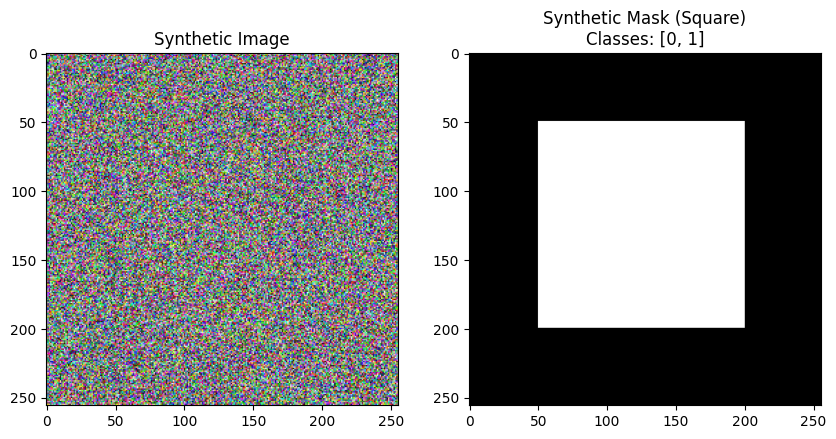

In [58]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

class RealSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, size=256):
        self.size = size

    def __len__(self):
        return 10

    def __getitem__(self, idx):
        image_np = np.random.randint(0, 255, (self.size, self.size, 3), dtype=np.uint8)
        mask_np = np.zeros((self.size, self.size), dtype=np.uint8)
        mask_np[50:200, 50:200] = 1

        image = Image.fromarray(image_np)
        mask = Image.fromarray(mask_np)

        return transforms.ToTensor()(image), torch.from_numpy(np.array(mask)).long()

ds = RealSegmentationDataset()
img, mask = ds[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img.permute(1, 2, 0))
ax[0].set_title("Synthetic Image")
ax[1].imshow(mask, cmap='gray')
ax[1].set_title(f"Synthetic Mask (Square)\nClasses: {mask.unique().tolist()}")
plt.show()

# Part 4: The UNet Architecture
We will implement a simplified UNet  from scratch.
A UNet has three parts:

The Encoder (Downsampling): Compresses the image into features.

The Bottleneck: The deepest, most abstract representation.

The Decoder (Upsampling): Expands features back to image size, using Skip Connections to recover lost details.

Architecture Specification (for implementation):

Input: 3 Channels (RGB)

Encoder Block 1:

Conv 3→64 (3×3, padding=1) + ReLU

MaxPool (2×2)

Encoder Block 2:

Conv 64→128 (3×3, padding=1) + ReLU

MaxPool (2×2)

Bottleneck:

Conv 128→256 (3×3, padding=1) + ReLU

Decoder Block 1 (Upsample):

Transposed Conv 256→128 (kernel=2, stride=2)

Skip Connection: Concatenate with output of Encoder 2. (Input channels become 128+128=256)

Conv 256→128 + ReLU

Decoder Block 2 (Upsample):

Transposed Conv 128→64 (kernel=2, stride=2)

Skip Connection: Concatenate with output of Encoder 1. (Input channels become 64+64=128)

Conv 128→64 + ReLU

Output Head:

Conv 64→n_classes (kernel=1)

In [59]:
class SimpleUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SimpleUNet, self).__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        b = self.bottleneck(p2)

        d1_up = self.up1(b)
        d1_cat = torch.cat([d1_up, e2], dim=1)
        d1 = self.dec1(d1_cat)

        d2_up = self.up2(d1)
        d2_cat = torch.cat([d2_up, e1], dim=1)
        d2 = self.dec2(d2_cat)

        return self.out(d2)

model = SimpleUNet(n_channels=3, n_classes=2)
x = torch.randn(1, 3, 256, 256)
y = model(x)
print("Input Shape:", x.shape)
print("Output Shape:", y.shape)

Input Shape: torch.Size([1, 3, 256, 256])
Output Shape: torch.Size([1, 2, 256, 256])


# Part 5: Metrics for Semantic Segmentation

In segmentation, every pixel is classified. That means we are effectively doing classification over **H × W pixels**.

For binary segmentation (e.g., background vs object), we define:

- True Positive (TP): Pixel correctly predicted as object
- True Negative (TN): Pixel correctly predicted as background
- False Positive (FP): Pixel predicted as object but is background
- False Negative (FN): Pixel predicted as background but is object

Common Metrics:

Accuracy:
    (TP + TN) / (TP + TN + FP + FN)

Precision:
    TP / (TP + FP)

Recall:
    TP / (TP + FN)

IoU (Intersection over Union):
    TP / (TP + FP + FN)

Dice Score:
    2TP / (2TP + FP + FN)

---

In **binary segmentation**, micro-averaged precision and recall collapse to accuracy
because we are aggregating over all pixels globally.

However:

- In multi-class segmentation, micro-averaging behaves like global pixel accuracy.
- Macro-averaging treats each class equally.
- IoU and Dice are more informative for segmentation because they ignore True Negatives.

Why ignore TN?

Because in segmentation, background pixels often dominate.
A model can get 95% accuracy by predicting everything as background.

That model would have:
- High Accuracy
- Zero IoU for the object
- Zero Recall for the object

Therefore:
For segmentation, IoU and Dice are preferred over plain accuracy.


In [60]:
def segmentation_metrics(pred, target, eps=1e-7):
    """
    pred: [H, W] predicted mask (0/1)
    target: [H, W] ground truth mask (0/1)
    """
    pred = pred.view(-1)
    target = target.view(-1)

    TP = torch.sum((pred == 1) & (target == 1)).float()
    TN = torch.sum((pred == 0) & (target == 0)).float()
    FP = torch.sum((pred == 1) & (target == 0)).float()
    FN = torch.sum((pred == 0) & (target == 1)).float()

    accuracy = (TP + TN) / (TP + TN + FP + FN + eps)
    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    iou = TP / (TP + FP + FN + eps)
    dice = (2 * TP) / (2 * TP + FP + FN + eps)

    return {
        "Accuracy": accuracy.item(),
        "Precision": precision.item(),
        "Recall": recall.item(),
        "IoU": iou.item(),
        "Dice": dice.item()
    }

Accuracy  : 0.9770
Precision : 0.9482
Recall    : 0.9779
IoU       : 0.9283
Dice      : 0.9628


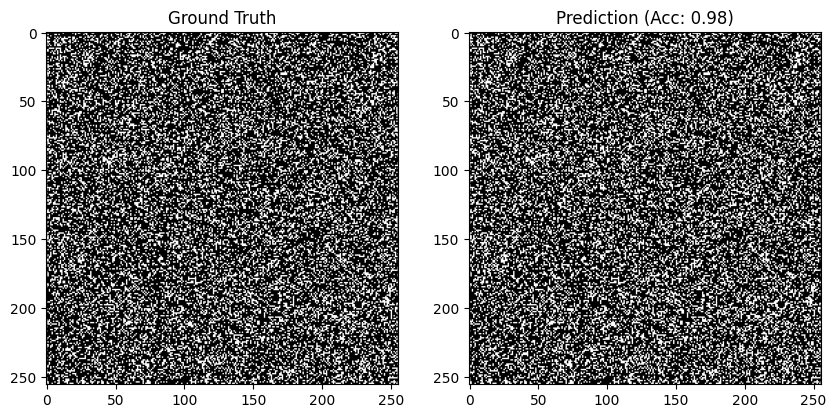

In [61]:
import torch
import matplotlib.pyplot as plt

gt_mask = (torch.randn(1, 256, 256) > 0.5).long()

noise = torch.randn(1, 256, 256) * 0.25
pred_mask = (gt_mask.float() + noise > 0.5).long()

results = segmentation_metrics(pred_mask[0], gt_mask[0])

for metric, value in results.items():
    print(f"{metric:10}: {value:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(gt_mask[0], cmap='gray')
ax[0].set_title("Ground Truth")
ax[1].imshow(pred_mask[0], cmap='gray')
ax[1].set_title(f"Prediction (Acc: {results['Accuracy']:.2f})")
plt.show()